In [2]:
# mostly from: https://github.com/HIPS/autograd/blob/master/examples/lstm.py

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import value_and_grad
from autograd.util import quick_grad_check
from scipy.optimize import minimize

class WeightsParser(object):
    """A helper class to index into a parameter vector."""
    def __init__(self):
        self.idxs_and_shapes = {}
        self.num_weights = 0

    def add_shape(self, name, shape):
        start = self.num_weights
        self.num_weights += np.prod(shape)
        self.idxs_and_shapes[name] = (slice(start, self.num_weights), shape)

    def get(self, vect, name):
        idxs, shape = self.idxs_and_shapes[name]
        return np.reshape(vect[idxs], shape)

def sigmoid(x):
    return 0.5*(np.tanh(x) + 1.0)   # Output ranges from 0 to 1.

def activations(weights, *args):
    cat_state = np.concatenate(args + (np.ones((args[0].shape[0],1)),), axis=1)
    return np.dot(cat_state, weights)

def logsumexp(X, axis=1):
    max_X = np.max(X)
    return max_X + np.log(np.sum(np.exp(X - max_X), axis=axis, keepdims=True))

def build_lstm(input_size, state_size, output_size):
    """Builds functions to compute the output of an LSTM."""
    parser = WeightsParser()
    parser.add_shape('init_cells',   (1, state_size))
    parser.add_shape('init_hiddens', (1, state_size))
    parser.add_shape('change',  (input_size + state_size + 1, state_size))
    parser.add_shape('forget',  (input_size + 2 * state_size + 1, state_size))
    parser.add_shape('ingate',  (input_size + 2 * state_size + 1, state_size))
    parser.add_shape('outgate', (input_size + 2 * state_size + 1, state_size))
    parser.add_shape('predict', (state_size + 1, output_size))

    def update_lstm(input, hiddens, cells, forget_weights, change_weights,
                                           ingate_weights, outgate_weights):
        """One iteration of an LSTM layer."""
        change  = np.tanh(activations(change_weights, input, hiddens))
        forget  = sigmoid(activations(forget_weights, input, cells, hiddens))
        ingate  = sigmoid(activations(ingate_weights, input, cells, hiddens))
        cells   = cells * forget + ingate * change
        outgate = sigmoid(activations(outgate_weights, input, cells, hiddens))
        hiddens = outgate * np.tanh(cells)
        return hiddens, cells

    def outputs(weights, inputs):
        """Goes from right to left, updating the state."""
        forget_weights  = parser.get(weights, 'forget')
        change_weights  = parser.get(weights, 'change')
        ingate_weights  = parser.get(weights, 'ingate')
        outgate_weights = parser.get(weights, 'outgate')
        predict_weights = parser.get(weights, 'predict')
        num_sequences = inputs.shape[1]
        hiddens = np.repeat(parser.get(weights, 'init_hiddens'), num_sequences, axis=0)
        cells   = np.repeat(parser.get(weights, 'init_cells'),   num_sequences, axis=0)
        output = []
        for input in inputs:  # Iterate over time steps.
            hiddens, cells = update_lstm(input, hiddens, cells, forget_weights,
                                         change_weights, ingate_weights, outgate_weights)
            cur_output = activations(predict_weights, hiddens)
            output.append(cur_output - logsumexp(cur_output))
        return output # Output normalized log-probabilities.

    def loss(weights, inputs, targets):
        logprobs = outputs(weights, inputs)
        loss_sum = 0.0
        for t in xrange(len(targets)):  # For every time step
            loss_sum -= np.sum(logprobs[t] * targets[t])
        return loss_sum / targets.shape[0] / targets.shape[1]

    def frac_err(weights, inputs, targets):
        return np.mean(np.argmax(targets, axis=2) != np.argmax(outputs(weights, inputs), axis=2))

    return outputs, loss, frac_err, parser.num_weights

In [2]:
def propagator(x_prev):
    return x_prev + npr.randn(len(x_prev))

In [3]:
sequence = np.ones((10000,10))
for i in range(sequence.shape[0]-1):
    sequence[i+1] = propagator(sequence[i])

In [44]:
test_sequence = np.ones((10000,10))
for i in range(test_sequence.shape[0]-1):
    test_sequence[i+1] = propagator(test_sequence[i])
test_sequences = np.array([test_sequence[i:i+50] for i in np.arange(len(test_sequence))[::100]])

In [4]:
sequence

array([[   1.        ,    1.        ,    1.        , ...,    1.        ,
           1.        ,    1.        ],
       [   0.86546271,    0.41927452,    1.6077388 , ...,    0.24145808,
           1.97233706,    0.27960651],
       [   1.91651458,    1.53942705,    0.94681116, ...,    0.31198352,
           2.07277154,   -0.93805937],
       ..., 
       [ -36.55290715,   19.52033039,  184.36880079, ...,  -73.9565832 ,
          55.89137022,   49.58430925],
       [ -36.71802296,   20.3563321 ,  183.50762367, ...,  -74.6171609 ,
          55.9025133 ,   49.53933771],
       [ -36.11007943,   19.80158979,  184.06266703, ...,  -75.90694373,
          56.79583274,   48.28114729]])

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

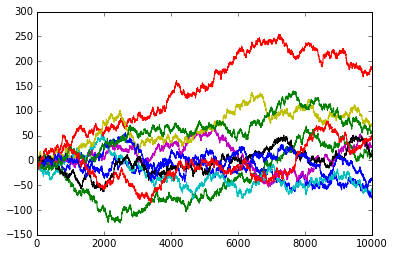

In [6]:
plt.plot(sequence)

In [20]:
pred_fun, loss_fun, frac_err, num_weights = build_lstm(sequence.shape[1],2,sequence.shape[1])

In [21]:
sequence.shape,num_weights

((10000, 10), 150)

In [26]:
sequences = np.array([sequence[i:i+50] for i in np.arange(len(sequence))[::100]])
sequences.shape

(100, 50, 10)

In [29]:
np.array(pred_fun(npr.randn(num_weights),sequences)).shape

(100, 50, 10)

In [30]:
loss_and_grad = value_and_grad(loss_fun)

In [34]:
train_inputs = train_targets = sequences

In [35]:
def training_loss_and_grad(weights):
    return loss_and_grad(weights, train_inputs, train_targets)

In [38]:
init_weights = npr.randn(num_weights)
quick_grad_check(loss_fun, init_weights, (train_inputs, train_targets))

Checking gradient of <function loss at 0x109c22398> at [ 0.64033781 -0.03821835 -1.39201816  1.51690309 -0.69414428 -1.59477662
 -1.38146619 -0.33381734  0.49911877  1.53580563 -1.9515511   2.30981994
  0.53702024 -1.05331539 -0.4652685   2.44826023 -0.19621757  0.34833697
  0.10465126  1.25208562 -0.36826091 -0.51107253 -1.22643478 -1.29076314
  0.92285498 -1.21901231 -0.60118261 -0.30473658  1.0181489   0.96406474
  2.26495358  1.27921378 -1.17727604  0.57290754  0.83149581  0.78153364
  1.83201514 -0.29836405  1.8705261  -0.69958069  1.63027131  0.49740386
 -1.98350736  1.27998265  1.30463086  0.12104948 -0.51296409  0.39948592
  0.59309433  0.32560529  0.58292832 -0.67698035  0.97748151  0.11302271
 -0.71186431  0.22010115 -0.30557443  0.1834762   1.16516163 -0.03312942
  0.63670965 -0.46201899 -0.32735993 -1.04210515  1.98505942  1.44252061
 -1.68263374  0.37110825  1.10043134 -0.27542119  1.69272905 -0.15023251
 -0.24202061  0.85892422 -1.19059749  0.89714609  0.10492682  1.54616

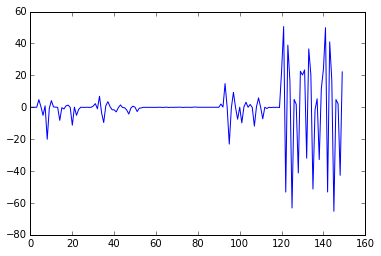

In [40]:
plt.plot(training_loss_and_grad(init_weights)[1])

In [41]:
def callback(weights):
    print("Train loss:", loss_fun(weights, train_inputs, train_targets))

result = minimize(training_loss_and_grad, init_weights, jac=True, method='CG',
                  options={'maxiter':10},callback=callback)

('Train loss:', -15201.500150584747)
('Train loss:', -29787.092141635156)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/autograd/core.py:107: RuntimeWarning: divide by zero encountered in log
  result = self.fun(*argvals, **kwargs)
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/autograd/core.py:107: RuntimeWarning: divide by zero encountered in divide
  result = self.fun(*argvals, **kwargs)



('Train loss:', -49876.898564795789)
('Train loss:', -81553.453687946661)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/autograd/core.py:107: RuntimeWarning: invalid value encountered in multiply
  result = self.fun(*argvals, **kwargs)
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/autograd/core.py:107: RuntimeWarning: overflow encountered in divide
  result = self.fun(*argvals, **kwargs)



('Train loss:', -5851117.7750497283)
('Train loss:', -10244745.483269451)
('Train loss:', -12360465.575867638)
('Train loss:', -98544700.264766499)
('Train loss:', -109744288.11716793)
('Train loss:', -137701966.52154922)


In [43]:
result.x

array([  6.29434850e+02,   2.50821501e+03,   2.42741970e+02,
         2.36784937e+01,  -2.68370965e+03,  -2.49864568e+03,
         2.70089981e+03,   7.20735710e+02,   9.99953835e+03,
         3.16924385e+03,  -2.71332072e+03,  -7.37081526e+03,
        -7.63022807e+00,   9.17171486e+02,   4.32460353e+03,
         5.95342311e+03,   5.72267946e+02,  -4.14033181e+03,
        -9.26845248e+02,   1.75127759e+03,   5.25083696e+03,
        -1.69828417e+02,   2.77289108e+03,   5.66577015e+03,
         2.90512374e+01,   1.68060807e+02,   5.20938033e+01,
         8.73327805e+01,   6.65551912e+01,   3.97685447e+02,
         3.08575036e+02,  -1.52735396e+03,  -8.70506535e+02,
        -3.31367318e+03,   2.79009926e+03,   4.78885424e+03,
         3.34486093e+03,  -1.91978953e+03,   1.03051135e+02,
         1.10500490e+03,  -9.98058734e+02,   1.55084980e+03,
         1.43814337e+03,  -7.25938877e+02,   1.12823225e+03,
         3.98246305e+01,   1.49115356e+03,   2.11970711e+03,
        -1.57515276e+03,

In [49]:
loss_fun(result.x,test_sequences,test_sequences)

nan

In [50]:
from msmbuilder.example_datasets import FsPeptide
fs = FsPeptide().get()

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [52]:
from msmbuilder.featurizer import DihedralFeaturizer
dhft = DihedralFeaturizer().fit_transform(fs.trajectories)

In [61]:
n_atoms = fs.trajectories[0].n_atoms
n_atoms

264

In [56]:
dhft[0].shape,len(dhft)

((10000, 84), 28)

In [59]:
train_inputs = train_targets = dhft[:20]

In [62]:
pred_fun, loss_fun, frac_err, num_weights = build_lstm(n_atoms,10,n_atoms)

In [ ]:
pre